# Image classification with dual-model endpoint

In [5]:
import boto3, time, os, urllib.request, numpy, json
import time
from time import gmtime, strftime
import re
from sagemaker import get_execution_role

role = get_execution_role()

bucket='ar51' # set to your own bucket

containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/image-classification:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/image-classification:latest'}

training_image = containers[boto3.Session().region_name]
print(training_image)

s3 = boto3.client('s3')
sagemaker = boto3.client(service_name='sagemaker')
runtime = boto3.client(service_name='sagemaker-runtime')

811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest


## Download the data set and upload it to S3

In [6]:
def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

        
def upload_to_s3(channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = channel + '/' + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)


# # caltech-256
download('http://data.mxnet.io/data/caltech-256/caltech-256-60-train.rec')
download('http://data.mxnet.io/data/caltech-256/caltech-256-60-val.rec')
upload_to_s3('validation', 'caltech-256-60-val.rec')
upload_to_s3('train', 'caltech-256-60-train.rec')

## Define common training parameters

In [7]:
training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": '' # model-specific
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p3.2xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": "", # model-specific
    "HyperParameters": {
        "image_shape": "3,224,224",
        "num_layers": "18",
        "num_training_samples": "15420",
        "num_classes": "257",
        "mini_batch_size": "128",
        "epochs": "2",
        "learning_rate": "", # model-specific
        "use_pretrained_model": "1"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/train/'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/validation/'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        }
    ]
}

## Train model A

In [8]:
# Model A parameters
job_name_prefix_modela = 'DEMO-imageclassification-modelA'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name_modela = job_name_prefix_modela + timestamp
s3_output_modela = 's3://{}/{}/output'.format(bucket, job_name_prefix_modela)

# Model A hyper parameters
lr_modela = '0.01'

# Train model A
training_params['TrainingJobName'] = job_name_modela
training_params['OutputDataConfig']['S3OutputPath'] = s3_output_modela
training_params['HyperParameters']['learning_rate'] = lr_modela

sagemaker.create_training_job(**training_params)

{'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:111652037296:training-job/demo-imageclassification-modela-2020-04-17-16-02-28',
 'ResponseMetadata': {'RequestId': '2b120eb9-a71b-4c7a-845d-d1f8d7219234',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2b120eb9-a71b-4c7a-845d-d1f8d7219234',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '126',
   'date': 'Fri, 17 Apr 2020 16:02:28 GMT'},
  'RetryAttempts': 0}}

In [9]:
# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name_modela)['TrainingJobStatus']
print('Training job name: {}'.format(job_name_modela))
print('Training job current status: {}'.format(status))

Training job name: DEMO-imageclassification-modelA-2020-04-17-16-02-28
Training job current status: InProgress


## Train model B

In [10]:
# Model B parameters
job_name_prefix_modelb = 'DEMO-imageclassification-modelB'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name_modelb = job_name_prefix_modelb + timestamp
s3_output_modelb = 's3://{}/{}/output'.format(bucket, job_name_prefix_modelb)

# Model B hyper parameters
lr_modelb = '0.001'

# Train model B
training_params['TrainingJobName'] = job_name_modelb
training_params['OutputDataConfig']['S3OutputPath'] = s3_output_modelb
training_params['HyperParameters']['learning_rate'] = lr_modelb

sagemaker.create_training_job(**training_params)

{'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:111652037296:training-job/demo-imageclassification-modelb-2020-04-17-16-02-31',
 'ResponseMetadata': {'RequestId': '06c1c9f2-fa55-4f57-b2fa-6d50d04f30a1',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '06c1c9f2-fa55-4f57-b2fa-6d50d04f30a1',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '126',
   'date': 'Fri, 17 Apr 2020 16:02:31 GMT'},
  'RetryAttempts': 0}}

In [11]:
# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name_modelb)['TrainingJobStatus']
print('Training job name: {}'.format(job_name_modelb))
print('Training job current status: {}'.format(status))

Training job name: DEMO-imageclassification-modelB-2020-04-17-16-02-31
Training job current status: InProgress


## Create models

In [13]:
# Create model A

info = sagemaker.describe_training_job(TrainingJobName=job_name_modela)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

hosting_image = containers[boto3.Session().region_name]
primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sagemaker.create_model(
    ModelName = job_name_modela,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

s3://ar51/DEMO-imageclassification-modelA/output/DEMO-imageclassification-modelA-2020-04-17-16-02-28/output/model.tar.gz
arn:aws:sagemaker:us-east-1:111652037296:model/demo-imageclassification-modela-2020-04-17-16-02-28


In [14]:
# Create model B

info = sagemaker.describe_training_job(TrainingJobName=job_name_modelb)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

hosting_image = containers[boto3.Session().region_name]
primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sagemaker.create_model(
    ModelName = job_name_modelb,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

s3://ar51/DEMO-imageclassification-modelB/output/DEMO-imageclassification-modelB-2020-04-17-16-02-31/output/model.tar.gz
arn:aws:sagemaker:us-east-1:111652037296:model/demo-imageclassification-modelb-2020-04-17-16-02-31


# Inference

### Create Endpoint Configuration

In [15]:
job_name_prefix = 'DEMO-imageclassification'

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc-' + timestamp

endpoint_config_response = sagemaker.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[
        {
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':job_name_modela,
        'VariantName':'Model-A',
        'InitialVariantWeight':1
        },
        {
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':job_name_modelb,
        'VariantName':'Model-B',
        'InitialVariantWeight':1
        }
    ])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: DEMO-imageclassification-epc--2020-04-17-16-13-24
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:111652037296:endpoint-config/demo-imageclassification-epc--2020-04-17-16-13-24


### Create Endpoint

In [16]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: DEMO-imageclassification-ep--2020-04-17-16-13-26
EndpointArn = arn:aws:sagemaker:us-east-1:111652037296:endpoint/demo-imageclassification-ep--2020-04-17-16-13-26


In [17]:
# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))

EndpointStatus = Creating


## Perform Inference

### Download test image

--2020-04-17 16:13:30--  http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/008_0007.jpg
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23750 (23K) [image/jpeg]
Saving to: ‘/tmp/test.jpg’

/tmp/test.jpg       100%[===================>]  23.19K  --.-KB/s    in 0.07s   

2020-04-17 16:13:31 (325 KB/s) - ‘/tmp/test.jpg’ saved [23750/23750]



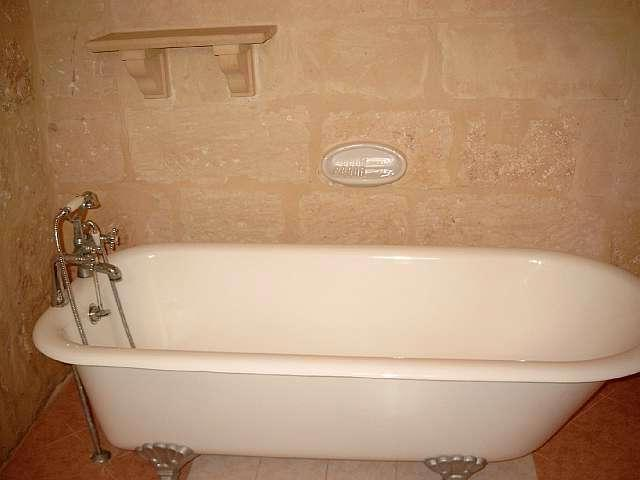

In [18]:
!wget -O /tmp/test.jpg http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/008_0007.jpg
file_name = '/tmp/test.jpg'
# test image
from IPython.display import Image
Image(file_name)  

In [22]:
with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)

response = runtime.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/x-image', Body=payload)

result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
print(result)
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = numpy.argmax(result)
object_categories = ['ak47', 'american-flag', 'backpack', 'baseball-bat', 'baseball-glove', 'basketball-hoop', 'bat', 'bathtub', 'bear', 'beer-mug', 'billiards', 'binoculars', 'birdbath', 'blimp', 'bonsai-101', 'boom-box', 'bowling-ball', 'bowling-pin', 'boxing-glove', 'brain-101', 'breadmaker', 'buddha-101', 'bulldozer', 'butterfly', 'cactus', 'cake', 'calculator', 'camel', 'cannon', 'canoe', 'car-tire', 'cartman', 'cd', 'centipede', 'cereal-box', 'chandelier-101', 'chess-board', 'chimp', 'chopsticks', 'cockroach', 'coffee-mug', 'coffin', 'coin', 'comet', 'computer-keyboard', 'computer-monitor', 'computer-mouse', 'conch', 'cormorant', 'covered-wagon', 'cowboy-hat', 'crab-101', 'desk-globe', 'diamond-ring', 'dice', 'dog', 'dolphin-101', 'doorknob', 'drinking-straw', 'duck', 'dumb-bell', 'eiffel-tower', 'electric-guitar-101', 'elephant-101', 'elk', 'ewer-101', 'eyeglasses', 'fern', 'fighter-jet', 'fire-extinguisher', 'fire-hydrant', 'fire-truck', 'fireworks', 'flashlight', 'floppy-disk', 'football-helmet', 'french-horn', 'fried-egg', 'frisbee', 'frog', 'frying-pan', 'galaxy', 'gas-pump', 'giraffe', 'goat', 'golden-gate-bridge', 'goldfish', 'golf-ball', 'goose', 'gorilla', 'grand-piano-101', 'grapes', 'grasshopper', 'guitar-pick', 'hamburger', 'hammock', 'harmonica', 'harp', 'harpsichord', 'hawksbill-101', 'head-phones', 'helicopter-101', 'hibiscus', 'homer-simpson', 'horse', 'horseshoe-crab', 'hot-air-balloon', 'hot-dog', 'hot-tub', 'hourglass', 'house-fly', 'human-skeleton', 'hummingbird', 'ibis-101', 'ice-cream-cone', 'iguana', 'ipod', 'iris', 'jesus-christ', 'joy-stick', 'kangaroo-101', 'kayak', 'ketch-101', 'killer-whale', 'knife', 'ladder', 'laptop-101', 'lathe', 'leopards-101', 'license-plate', 'lightbulb', 'light-house', 'lightning', 'llama-101', 'mailbox', 'mandolin', 'mars', 'mattress', 'megaphone', 'menorah-101', 'microscope', 'microwave', 'minaret', 'minotaur', 'motorbikes-101', 'mountain-bike', 'mushroom', 'mussels', 'necktie', 'octopus', 'ostrich', 'owl', 'palm-pilot', 'palm-tree', 'paperclip', 'paper-shredder', 'pci-card', 'penguin', 'people', 'pez-dispenser', 'photocopier', 'picnic-table', 'playing-card', 'porcupine', 'pram', 'praying-mantis', 'pyramid', 'raccoon', 'radio-telescope', 'rainbow', 'refrigerator', 'revolver-101', 'rifle', 'rotary-phone', 'roulette-wheel', 'saddle', 'saturn', 'school-bus', 'scorpion-101', 'screwdriver', 'segway', 'self-propelled-lawn-mower', 'sextant', 'sheet-music', 'skateboard', 'skunk', 'skyscraper', 'smokestack', 'snail', 'snake', 'sneaker', 'snowmobile', 'soccer-ball', 'socks', 'soda-can', 'spaghetti', 'speed-boat', 'spider', 'spoon', 'stained-glass', 'starfish-101', 'steering-wheel', 'stirrups', 'sunflower-101', 'superman', 'sushi', 'swan', 'swiss-army-knife', 'sword', 'syringe', 'tambourine', 'teapot', 'teddy-bear', 'teepee', 'telephone-box', 'tennis-ball', 'tennis-court', 'tennis-racket', 'theodolite', 'toaster', 'tomato', 'tombstone', 'top-hat', 'touring-bike', 'tower-pisa', 'traffic-light', 'treadmill', 'triceratops', 'tricycle', 'trilobite-101', 'tripod', 't-shirt', 'tuning-fork', 'tweezer', 'umbrella-101', 'unicorn', 'vcr', 'video-projector', 'washing-machine', 'watch-101', 'waterfall', 'watermelon', 'welding-mask', 'wheelbarrow', 'windmill', 'wine-bottle', 'xylophone', 'yarmulke', 'yo-yo', 'zebra', 'airplanes-101', 'car-side-101', 'faces-easy-101', 'greyhound', 'tennis-shoes', 'toad', 'clutter']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

[0.003642966505140066, 0.001888476894237101, 0.000527330907061696, 0.0026867156848311424, 0.0033936111722141504, 0.0025034602731466293, 0.0033778678625822067, 0.0018172627314925194, 0.005772801581770182, 0.0012887961929664016, 0.0037988179828971624, 0.000869322509970516, 0.0019296506652608514, 0.010377633385360241, 0.0013111303560435772, 0.0019143179524689913, 0.010567311197519302, 0.010630078613758087, 0.00509607931599021, 0.00262591615319252, 0.005388994701206684, 0.00012606105883605778, 0.012074315920472145, 0.0009653333108872175, 0.0029823370277881622, 0.001375039224512875, 0.00257681030780077, 0.0014610278885811567, 0.000430478248745203, 0.0027042946312576532, 0.00213369308039546, 0.0017659717705100775, 0.006652878597378731, 0.0033678803592920303, 0.0028958397451788187, 0.002751220017671585, 0.023457836359739304, 0.0006678772042505443, 0.0012459811987355351, 0.019810575991868973, 0.021931596100330353, 0.004793815314769745, 0.0010105744004249573, 0.0005449022864922881, 0.0047653098

In [59]:
import os
import random

path ='/home/ec2-user/SageMaker/datasets/256_ObjectCategoriesimage'
files = os.listdir(path)

for i in range(10000):
    index = random.randrange(0, len(files))
    #print(files[index])
    file_name = path + '/' + files[index]
    with open(file_name, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)

    response = runtime.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/x-image', Body=payload)



In [53]:
import boto3

client = boto3.client('application-autoscaling')

response = client.register_scalable_target(
    ServiceNamespace='sagemaker',
    ResourceId='endpoint/DEMO-imageclassification-ep--2020-04-17-16-13-26/variant/Model-A',
    ScalableDimension='sagemaker:variant:DesiredInstanceCount',
    MinCapacity=1,
    MaxCapacity=4
)

print(response)

{'ResponseMetadata': {'RequestId': 'bc891b3a-4055-42d5-a012-4589fa741f62', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'bc891b3a-4055-42d5-a012-4589fa741f62', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'date': 'Fri, 17 Apr 2020 18:20:52 GMT'}, 'RetryAttempts': 0}}


In [54]:
response = client.put_scaling_policy(
    PolicyName='DEMO-imageclassification-ScalingPolicy',
    ServiceNamespace='sagemaker',
    ResourceId='endpoint/DEMO-imageclassification-ep--2020-04-17-16-13-26/variant/Model-A',
    ScalableDimension='sagemaker:variant:DesiredInstanceCount',
    PolicyType='TargetTrackingScaling',
    TargetTrackingScalingPolicyConfiguration={
        'TargetValue': 5.0,
        'PredefinedMetricSpecification': {
            'PredefinedMetricType': 'SageMakerVariantInvocationsPerInstance',
        },
        'ScaleInCooldown': 600,
        'ScaleOutCooldown': 300
    }
)

print(response)

{'PolicyARN': 'arn:aws:autoscaling:us-east-1:111652037296:scalingPolicy:ea8799af-9e7a-4e1a-a2d2-9160ebc9575f:resource/sagemaker/endpoint/DEMO-imageclassification-ep--2020-04-17-16-13-26/variant/Model-A:policyName/DEMO-imageclassification-ScalingPolicy', 'Alarms': [{'AlarmName': 'TargetTracking-endpoint/DEMO-imageclassification-ep--2020-04-17-16-13-26/variant/Model-A-AlarmHigh-823af71b-7fb8-4dd1-8a6e-df4099356263', 'AlarmARN': 'arn:aws:cloudwatch:us-east-1:111652037296:alarm:TargetTracking-endpoint/DEMO-imageclassification-ep--2020-04-17-16-13-26/variant/Model-A-AlarmHigh-823af71b-7fb8-4dd1-8a6e-df4099356263'}, {'AlarmName': 'TargetTracking-endpoint/DEMO-imageclassification-ep--2020-04-17-16-13-26/variant/Model-A-AlarmLow-be6f63b6-a5c3-4ff0-a488-f04cfa605d1a', 'AlarmARN': 'arn:aws:cloudwatch:us-east-1:111652037296:alarm:TargetTracking-endpoint/DEMO-imageclassification-ep--2020-04-17-16-13-26/variant/Model-A-AlarmLow-be6f63b6-a5c3-4ff0-a488-f04cfa605d1a'}], 'ResponseMetadata': {'RequestI

In [55]:
response = client.register_scalable_target(
    ServiceNamespace='sagemaker',
    ResourceId='endpoint/DEMO-imageclassification-ep--2020-04-17-16-13-26/variant/Model-B',
    ScalableDimension='sagemaker:variant:DesiredInstanceCount',
    MinCapacity=1,
    MaxCapacity=3
)

print(response)

{'ResponseMetadata': {'RequestId': 'c23bfbb9-bceb-481e-84e1-aabeeaa11471', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'c23bfbb9-bceb-481e-84e1-aabeeaa11471', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'date': 'Fri, 17 Apr 2020 18:20:57 GMT'}, 'RetryAttempts': 0}}


In [56]:
response = client.put_scaling_policy(
    PolicyName='DEMO-imageclassification-ScalingPolicy',
    ServiceNamespace='sagemaker',
    ResourceId='endpoint/DEMO-imageclassification-ep--2020-04-17-16-13-26/variant/Model-B',
    ScalableDimension='sagemaker:variant:DesiredInstanceCount',
    PolicyType='TargetTrackingScaling',
    TargetTrackingScalingPolicyConfiguration={
        'TargetValue': 5.0,
        'PredefinedMetricSpecification': {
            'PredefinedMetricType': 'SageMakerVariantInvocationsPerInstance',
        },
        'ScaleInCooldown': 600,
        'ScaleOutCooldown': 300
    }
)

print(response)

{'PolicyARN': 'arn:aws:autoscaling:us-east-1:111652037296:scalingPolicy:05e14d83-02da-46c1-967b-690f6f08308e:resource/sagemaker/endpoint/DEMO-imageclassification-ep--2020-04-17-16-13-26/variant/Model-B:policyName/DEMO-imageclassification-ScalingPolicy', 'Alarms': [{'AlarmName': 'TargetTracking-endpoint/DEMO-imageclassification-ep--2020-04-17-16-13-26/variant/Model-B-AlarmHigh-f3521aae-35d3-4352-bd8a-6f7568daa82e', 'AlarmARN': 'arn:aws:cloudwatch:us-east-1:111652037296:alarm:TargetTracking-endpoint/DEMO-imageclassification-ep--2020-04-17-16-13-26/variant/Model-B-AlarmHigh-f3521aae-35d3-4352-bd8a-6f7568daa82e'}, {'AlarmName': 'TargetTracking-endpoint/DEMO-imageclassification-ep--2020-04-17-16-13-26/variant/Model-B-AlarmLow-f248495b-b82d-4138-9ef5-4f1f0345b1a5', 'AlarmARN': 'arn:aws:cloudwatch:us-east-1:111652037296:alarm:TargetTracking-endpoint/DEMO-imageclassification-ep--2020-04-17-16-13-26/variant/Model-B-AlarmLow-f248495b-b82d-4138-9ef5-4f1f0345b1a5'}], 'ResponseMetadata': {'RequestI

In [58]:
import os
import random

path ='/home/ec2-user/SageMaker/datasets/256_ObjectCategoriesimage'
files = os.listdir(path)

while True:
    index = random.randrange(0, len(files))
    #print(files[index])
    file_name = path + '/' + files[index]
    with open(file_name, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)

    response = runtime.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/x-image', Body=payload)



ConnectionClosedError: Connection was closed before we received a valid response from endpoint URL: "https://runtime.sagemaker.us-east-1.amazonaws.com/endpoints/DEMO-imageclassification-ep--2020-04-17-16-13-26/invocations".

In [60]:
job_name_prefix = 'DEMO-imageclassification'

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc-R' + timestamp

endpoint_config_response = sagemaker.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[
        {
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':job_name_modelb,
        'VariantName':'Model-A-R',
        'InitialVariantWeight':1
        },
        {
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':job_name_modela,
        'VariantName':'Model-B-R',
        'InitialVariantWeight':5
        }
    ])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: DEMO-imageclassification-epc-R-2020-04-19-01-45-02
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:111652037296:endpoint-config/demo-imageclassification-epc-r-2020-04-19-01-45-02


In [63]:
response = client.deregister_scalable_target(
    ServiceNamespace='sagemaker',
    ResourceId='endpoint/DEMO-imageclassification-ep--2020-04-17-16-13-26/variant/Model-B',
    ScalableDimension='sagemaker:variant:DesiredInstanceCount'
)

print(response)

{'ResponseMetadata': {'RequestId': '90c38bb7-1275-4d07-a2fd-21dac0bc3a9d', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '90c38bb7-1275-4d07-a2fd-21dac0bc3a9d', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'date': 'Sun, 19 Apr 2020 01:54:33 GMT'}, 'RetryAttempts': 0}}


In [64]:
response = client.deregister_scalable_target(
    ServiceNamespace='sagemaker',
    ResourceId='endpoint/DEMO-imageclassification-ep--2020-04-17-16-13-26/variant/Model-A',
    ScalableDimension='sagemaker:variant:DesiredInstanceCount'
)

print(response)

{'ResponseMetadata': {'RequestId': 'd92035a0-2477-4f6a-9891-43729eb0b83f', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'd92035a0-2477-4f6a-9891-43729eb0b83f', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'date': 'Sun, 19 Apr 2020 01:55:26 GMT'}, 'RetryAttempts': 0}}


In [65]:
response = sagemaker.update_endpoint(
    EndpointName='DEMO-imageclassification-ep--2020-04-17-16-13-26',
    EndpointConfigName='DEMO-imageclassification-epc-R-2020-04-19-01-45-02',
    RetainAllVariantProperties=True,
)

print(response)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:111652037296:endpoint/demo-imageclassification-ep--2020-04-17-16-13-26', 'ResponseMetadata': {'RequestId': '2eaf2df4-39df-49fb-9f8d-d364e176be4b', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '2eaf2df4-39df-49fb-9f8d-d364e176be4b', 'content-type': 'application/x-amz-json-1.1', 'content-length': '116', 'date': 'Sun, 19 Apr 2020 01:55:30 GMT'}, 'RetryAttempts': 0}}


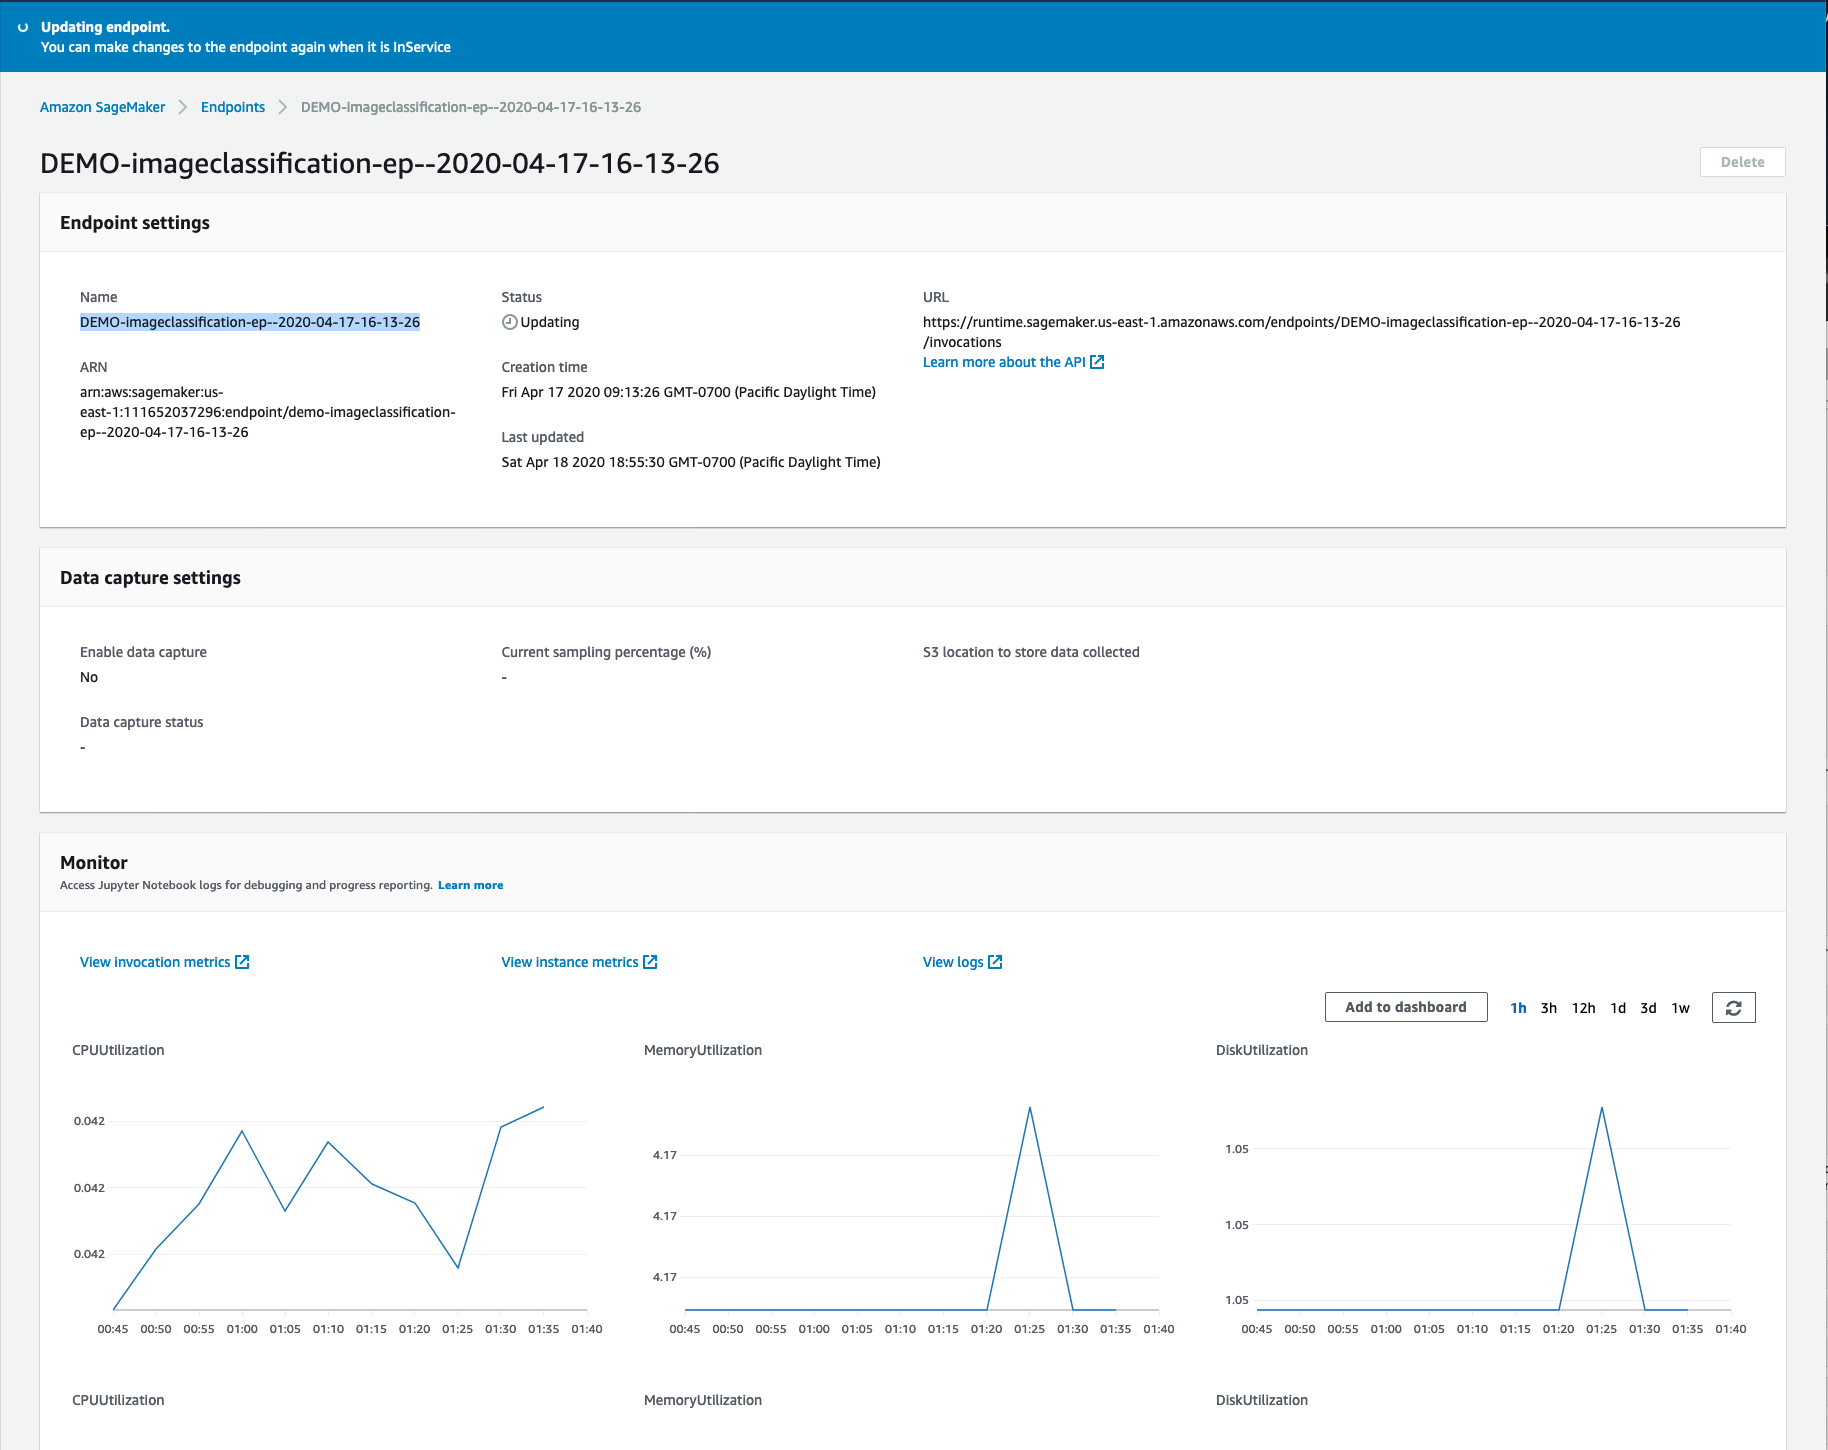

In [67]:
from IPython.display import Image
Image('EndPoint-Updating.png')  

In [70]:
%%time

# print the status of the endpoint

endpoint_name = 'DEMO-imageclassification-ep--2020-04-17-16-13-26'

resp = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Updating':
    time.sleep(60)
    resp = sagemaker.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)    
    

Status: Updating
Status: Updating
Status: Updating
Status: Updating
Status: InService
CPU times: user 73.4 ms, sys: 53 µs, total: 73.4 ms
Wall time: 4min


### Clean up

When we're done with the endpoint, we can just delete it and the backing instances will be released.  Run the following cell to delete the endpoint.

In [ ]:
#sage.delete_endpoint(EndpointName=endpoint_name)